<a href="https://colab.research.google.com/github/AnastasiaBrinati/esercizi-PMCSN-23-24/blob/main/esercizio_feedback_simulazione.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ESERCIZIO SSQ CON FEEDBACK

####imports

In [5]:
pip install simpy

In [6]:
import simpy
import random
from typing_extensions import NamedTuple
import datetime

In [7]:
import numpy as np
from matplotlib import pyplot as plt

#### Resources

In [44]:
SIM_TIME = 100000

TIMES = {
    'arrival_times' : [],
    'waiting_times' : [],
    'service_times' : [],
    'response_times' : []
}

In [45]:
class System(NamedTuple):
    server: simpy.Resource

In [46]:
# use one random number generator to generate multiple
# “streams” of random numbers using multiple initial seeds as entry points, one for each
# stochastic system component. _leemis_chapter3

from numpy.random import default_rng

RANDOM_SEED = 123456
parent_rng = default_rng(RANDOM_SEED)
streams = parent_rng.spawn(3)

stream_arrivi = streams[0]
stream_feedback = streams[1]
stream_servizi = streams[2]

#### Fun-cs

In [47]:
# EVENTUAL FEEDBACK

def feedback():
  beta = 0.2
  r = stream_feedback.random()
  if(r <= beta):
    # job gets feed back into the system
    return 1
  # job leaves the system
  return 0

In [48]:
def job(env, id, sys):

  flag = True
  while(flag):

    arrival_at_queue = env.now
    print("job " + id + ' arrived at %f' % arrival_at_queue)

    # Enter the queue, candidates as a request for the server
    with sys.server.request() as my_turn:
      # Wait until it's our turn
      yield my_turn
      waiting_time = env.now - arrival_at_queue
      print('job ' + id +' waited for %f' % waiting_time)

      # Start the service
      print('job '+id+' starts being served at %f' % env.now)
      service_time = stream_servizi.uniform(1,2)
      yield env.timeout(service_time)
      # The service process has finished: Resource released automatically
      print('job '+id+' finished service at %f' % env.now)

      # Save some data
      TIMES['service_times'].append(service_time)
      TIMES['waiting_times'].append(waiting_time)
      TIMES['response_times'].append(waiting_time+service_time)


    if(not feedback()):
      print("job " + id + " leaving the system at %f " % env.now)
      flag = False

In [49]:
# GENERATING THE JOBS ARRIVAL FLOW

arrival_rate = 0.5

def job_arrivals(env, system):
    id = 0
    while True:
        # timeout interarrival times, waiting before generating another job
        yield env.timeout(stream_arrivi.exponential(1/arrival_rate))

        # simplifying the example with fixed job size (fixed service times)
        env.process(job(env, str(id), system))
        id += 1

#### Simulation

In [50]:
# Setup and start the simulation
env = simpy.Environment()

# Create system
system = System(
    server = simpy.Resource(env, capacity=1)
    )

# Start process and run until SIM_TIME
env.process(job_arrivals(env, system))
env.run(until=SIM_TIME)

Output streaming troncato alle ultime 5000 righe.
job 49204 starts being served at 98348.422068
job 49222 arrived at 98349.679828
job 49204 finished service at 98350.128008
job 49204 arrived at 98350.128008
job 49205 waited for 33.281939
job 49205 starts being served at 98350.128008
job 49205 finished service at 98351.423124
job 49205 leaving the system at 98351.423124 
job 49206 waited for 33.334770
job 49206 starts being served at 98351.423124
job 49206 finished service at 98352.898722
job 49206 leaving the system at 98352.898722 
job 49207 waited for 33.844042
job 49207 starts being served at 98352.898722
job 49207 finished service at 98354.107374
job 49207 leaving the system at 98354.107374 
job 49208 waited for 33.684530
job 49208 starts being served at 98354.107374
job 49223 arrived at 98355.568757
job 49208 finished service at 98356.015016
job 49208 arrived at 98356.015016
job 49209 waited for 31.888998
job 49209 starts being served at 98356.015016
job 49224 arrived at 98356.804

### Analysis and Results

In [52]:
def avg_waiting_times(times):
  l = []
  waiting_times=times
  for i in range(len(times)):
    l.append(sum(waiting_times) / len(waiting_times))
    waiting_times.pop()
  return l[::-1]

In [53]:
queuing_time_avg = sum(TIMES['waiting_times']) / len(TIMES['waiting_times'])
print("Avg waiting time: %f " % queuing_time_avg)

avg_waiting_times = avg_waiting_times(TIMES['waiting_times'])

Avg waiting time: 14.007275 


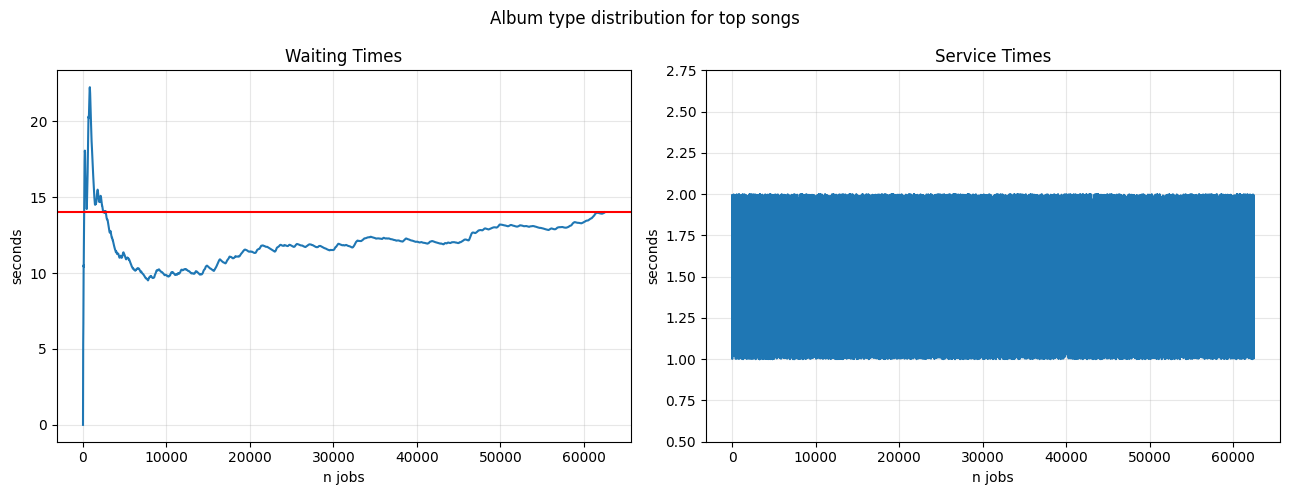

In [54]:
fig = plt.figure(figsize=(13,5))
fig.suptitle('Album type distribution for top songs');
ax = fig.subplots(nrows=1, ncols=2)

#ax[0].plot(TIMES['waiting_times'])
ax[0].plot(avg_waiting_times)
ax[0].axhline(queuing_time_avg, color='red')
ax[0].set_ylabel('seconds')
ax[0].set_xlabel("n jobs")
#ax[0].set_yticks(np.arange(0,45,2))
#ax[0].set_xticks(np.arange(0,700,50))
ax[0].set_title("Waiting Times")
ax[0].grid(alpha=0.3)

ax[1].plot(TIMES['service_times'])
ax[1].set_ylabel('seconds')
ax[1].set_xlabel("n jobs")
ax[1].set_yticks(np.arange(0.5,3,0.25))
#ax[1].set_xticks(np.arange(0,700,50))
ax[1].set_title("Service Times")
ax[1].grid(alpha=0.3)

fig.tight_layout()